# FFTW and FFTs

這一節，我們介紹如何使用 package FFTW。

In [1]:
using FFTW
using LinearAlgebra
using Plots
using BenchmarkTools

## Section 1 - Fast Fourier Transform(fft) 的輸入方式
fft 是一個將函數值轉成傅立葉係數的指令，因此，我們在 fft() 的括號裡放入函數值所形成的向量。

### Section 1.1 - 1D fft

當資料是一維的時候輸入行向量或列向量，結果是一樣的。如以下兩個例子：

In [2]:
fft([0; 1; 2; 1])

4-element Array{Complex{Float64},1}:
  4.0 + 0.0im
 -2.0 + 0.0im
  0.0 + 0.0im
 -2.0 + 0.0im

In [3]:
fft([0, 1, 2, 1])

4-element Array{Complex{Float64},1}:
  4.0 + 0.0im
 -2.0 + 0.0im
  0.0 + 0.0im
 -2.0 + 0.0im

### Section 1.2 - 2D fft

當資料是個矩陣時，julia 中的 fft 則是對這矩陣做二維的 fft。

**注意：** Matlab 中對矩陣做二維 fft 的指令是 fft2。

如以下例子：

In [4]:
A=[0 0 0 0; 1 1 1 1; 2 2 2 2; 1 1 1 1]

4×4 Array{Int64,2}:
 0  0  0  0
 1  1  1  1
 2  2  2  2
 1  1  1  1

In [5]:
fft(A)

4×4 Array{Complex{Float64},2}:
 16.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -8.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -8.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

從結果可以看出 Julia 的 fft 指令做矩陣的傅立葉轉換時，是先做行向量，並將結果依照行向量儲存在該行。全部做完一次之後再做列向量，再將該列的結果儲存在該列。 

我們把步驟拆解開來看，

1. 上例中，先做 fft([0;1;2;1]) = [4;-2;0;-2]。矩陣中四行都做完會得到

In [6]:
[4 4 4 4; -2 -2 -2 -2; 0 0 0 0; -2 -2 -2 -2]

4×4 Array{Int64,2}:
  4   4   4   4
 -2  -2  -2  -2
  0   0   0   0
 -2  -2  -2  -2

2. 接下來再做列向量。由於現在每一列都是常數函數，所以我們可以預期它的結果只有在第一個傅立葉係數有值，其他為 0。(第一個傅立葉係數 $\hat{f}_0$ 儲存的是函數常數的部分，也就是 $e^0$ 的係數)。底下是 f(x) = 4 的傅立葉轉換結果，結果是 $4 \times N$，$N$ 是取點的各數，在這裡是取樣 4 個點 (細節在稍後的小節中會提到)。其他列的計算結果雷同，fft([-2 -2 -2 -2]) = [-8 0 0 0], fft([0 0 0 0]) = [0 0 0 0]。

In [7]:
fft([4 4 4 4])

1×4 Array{Complex{Float64},2}:
 16.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

把每一列的結果按照每一列的順序排好就會得到

In [8]:
[16 0 0 0; -8 0 0 0; 0 0 0 0; -8 0 0 0]

4×4 Array{Int64,2}:
 16  0  0  0
 -8  0  0  0
  0  0  0  0
 -8  0  0  0

## Section 2 - FFT 的運算時間與運算量

下列的兩個例子告訴我們，fft 這個內建的函數運算速度很快，將一個 (2^17)*1 的向量轉成傅立葉係數不會超過 0.2 秒。

如果向量的長度為 2 的倍數，運算速度會比較快

In [9]:
x = randn(2^17)
@benchmark y = fft(x)

BenchmarkTools.Trial: 
  memory estimate:  4.00 MiB
  allocs estimate:  54
  --------------
  minimum time:     2.350 ms (0.00% GC)
  median time:      2.544 ms (0.00% GC)
  mean time:        2.949 ms (12.50% GC)
  maximum time:     68.364 ms (95.70% GC)
  --------------
  samples:          1689
  evals/sample:     1

如果向量的長度不是 2 的倍數，運算速度會比較慢

In [10]:
x = randn(2^17-1)
@benchmark y = fft(x)

BenchmarkTools.Trial: 
  memory estimate:  4.00 MiB
  allocs estimate:  54
  --------------
  minimum time:     19.192 ms (0.00% GC)
  median time:      20.923 ms (0.00% GC)
  mean time:        22.419 ms (3.18% GC)
  maximum time:     90.180 ms (73.82% GC)
  --------------
  samples:          223
  evals/sample:     1

### FFT 的運算量

FFT 的運算量約為 nlog(n), n 為向量長度. 接下來我們要以程式來驗證. 

以下 `cpt` 這個函數會將一個 $10^k\times 1$ 的向量做 FFT.

In [11]:
function cpt(k)
    x = randn(10^k);
    y = fft(x);
end

cpt (generic function with 1 method)

先以 `benchmark` 執行一次看看 $k=5$ 的效率.

In [12]:
y = @benchmark cpt(5)

BenchmarkTools.Trial: 
  memory estimate:  3.82 MiB
  allocs estimate:  56
  --------------
  minimum time:     2.342 ms (0.00% GC)
  median time:      2.543 ms (0.00% GC)
  mean time:        3.262 ms (12.64% GC)
  maximum time:     69.608 ms (94.31% GC)
  --------------
  samples:          1529
  evals/sample:     1

可以將 `@benchmark` 執行結果存起來成為一個 `trial`, 要取出時間就用 `time` 來取出來, 取出的時間單位是 (ns).

我們把 k = $2$ ~ $7$ 計算的結果分別儲存在 t2 ~ t7 中。

In [13]:
x2 = @benchmark cpt(2); t2 = time(x2);
x3 = @benchmark cpt(3); t3 = time(x3);
x4 = @benchmark cpt(4); t4 = time(x4);
x5 = @benchmark cpt(5); t5 = time(x5);
x6 = @benchmark cpt(6); t6 = time(x6);
x7 = @benchmark cpt(7); t7 = time(x7);

為了方便畫圖，我們把計算的時間存在 y1 中，y2為 nlog(n)，n = $10^2$ ~ $10^7$。

In [14]:
x = [10^2, 10^3, 10^4, 10^5, 10^6, 10^7];
y1 = [t2, t3, t4, t5, t6, t7];
y2 = [2*10^2, 3*10^3, 4*10^4, 5*10^5, 6*10^6, 7*10^7];

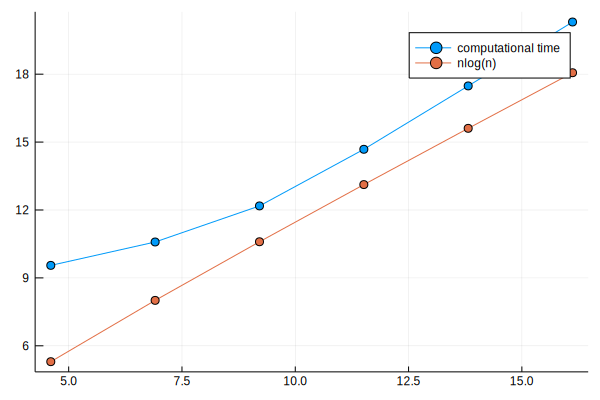

In [15]:
p = plot(log.(x),log.(y1),label="computational time",marker=:circle)
plot!(p,log.(x),log.(y2),label="nlog(n)",marker=:circle)

我們將計算所花的時間和 nlog(n) 分別取對數畫在同一張圖上，會發現斜率幾乎一樣。因此 fft 的運算量約為 nlog(n)。

補充：

我們可以利用 varinfo() 查看所有變數

In [16]:
varinfo()

| name |        size | summary                     |
|:---- | -----------:|:--------------------------- |
| A    |   168 bytes | 4×4 Array{Int64,2}          |
| Base |             | Module                      |
| Core |             | Module                      |
| Main |             | Module                      |
| cpt  |     0 bytes | typeof(cpt)                 |
| p    |  34.341 KiB | Plots.Plot{Plots.GRBackend} |
| t2   |     8 bytes | Float64                     |
| t3   |     8 bytes | Float64                     |
| t4   |     8 bytes | Float64                     |
| t5   |     8 bytes | Float64                     |
| t6   |     8 bytes | Float64                     |
| t7   |     8 bytes | Float64                     |
| x    |    88 bytes | 6-element Array{Int64,1}    |
| x2   | 156.422 KiB | Trial(14.083 μs)            |
| x3   | 156.422 KiB | Trial(39.591 μs)            |
| x4   | 156.422 KiB | Trial(194.876 μs)           |
| x5   |  20.109 KiB | Trial(2.377 ms)             |
| x6   |   1.938 KiB | Trial(39.084 ms)            |
| x7   |   304 bytes | Trial(658.195 ms)           |
| y    |  24.063 KiB | Trial(2.342 ms)             |
| y1   |    88 bytes | 6-element Array{Float64,1}  |
| y2   |    88 bytes | 6-element Array{Int64,1}    |


## Section 3 - FFT 的準確度

下列我們以兩個例子說明 fft 求傅立葉係數的誤差。

我們將要轉換的值儲存在變數 a 中，利用 fft(a) 取其傅立葉係數，再利用 ifft(fft(a)) 轉回原來的函數值。

如果 fft 與 ifft 這兩個函數可以很準確的把函數值轉成傅立葉係數，再轉回原函數，那麼 ifft(fft(a)) 與 a 的值差距應該要很小。

因此我們用 norm 計算 ifft(fft(a)) 與 a 之間的誤差。下列兩個結果顯示，轉換的誤差會小於機器誤差。

Julia 中，norm 這個函數可以用來算向量與矩陣的範數，

norm(A, Inf) 用來計算 A 的 infinity norm，即取出向量中絕對值最大的元素。

norm(A, p) 用來計算 A 的 p norm，$||A||_p = (\sum_{i = 1}^n |a_i|^p)^{1/p}$，其中 $a_i$ 是 A 中的元素，A 的長度為 n。

norm(A) 是用預設的值，算的是 2-norm。

我們用兩個例子來檢驗。令 a 是複數，實部與虛部都取亂數。
1. rand(8) 是從 0 到 1 之間取 8 個亂數，值為小數。
2. rand(-10:10,8) 是從 -10 到 10 之間取 8 個亂數，值為整數。

In [17]:
a = rand(8) + im*rand(8);
norm(ifft(fft(a)) - a)

2.1677797545656835e-16

In [18]:
a = rand(-10:10, 8) + im*rand(-10:10, 8);
norm(ifft(fft(a)) - a, Inf)

8.881784197001252e-16